In [ ]:
import json
import random
import itertools
import sys
import pandas as pd
import tensorflow as tf
import numpy as np
import keras_tuner as kt
import category_encoders
import hashlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from datetime import datetime
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.feature_extraction import FeatureHasher
from tensorflow.keras.callbacks import EarlyStopping


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [ ]:
def encode_time(original_dataframe: pd.DataFrame, columns_to_encode: list[str], period: int) -> pd.DataFrame:
    for column in columns_to_encode:
        original_dataframe[column] = original_dataframe[column].astype('float64')
        original_dataframe[column + '_sin'] = np.sin(2 * np.pi * original_dataframe[column] / period)
        original_dataframe[column + '_cos'] = np.cos(2 * np.pi * original_dataframe[column] / period)
    original_dataframe = original_dataframe.drop(columns=columns_to_encode)
    return original_dataframe

def encode_time_utc(original_dataframe: pd.DataFrame, column_to_encode: str, pattern: str) -> pd.DataFrame:
    timestamps = []
    for i in range(len(original_dataframe)):
        time_stamp = original_dataframe.loc[i, column_to_encode]
        if time_stamp.__contains__("."):
            pattern = '%Y-%m-%dT%H:%M:%S.%fZ'
        else: 
            pattern = '%Y-%m-%dT%H:%M:%SZ'
        time_stamp = datetime.strptime(original_dataframe.loc[i, column_to_encode], pattern)
        timestamps.append(time_stamp.timestamp())

    original_dataframe[column_to_encode] = timestamps
    return original_dataframe

def encode_time_local(original_dataframe: pd.DataFrame, column_to_encode: str, pattern: str) -> pd.DataFrame:
    timestamps = []
    for i in range(len(original_dataframe)):
        time_stamp = original_dataframe.loc[i, column_to_encode]
        if time_stamp.__contains__("."):
            pattern = '%Y-%m-%dT%H:%M:%S.%f'
        else: 
            pattern = '%Y-%m-%dT%H:%M:%S'
        time_stamp = datetime.strptime(original_dataframe.loc[i, column_to_encode], pattern)
        timestamps.append(time_stamp.timestamp())

    original_dataframe[column_to_encode] = timestamps
    return original_dataframe


def number_of_unique_values_per_column(dataframe: pd.DataFrame) -> None:
    print([(column, dataframe[column].nunique()) for column in dataframe.columns])

def onehot_encode_column(original_dataframe: pd.DataFrame, column_to_encode: str) -> pd.DataFrame:
    encoder = OneHotEncoder()
    encoded_column = encoder.fit_transform(original_dataframe[[column_to_encode]])
    encoded_column_dataframe = pd.DataFrame(encoded_column.toarray(), columns=encoder.get_feature_names_out([column_to_encode]))
    original_dataframe = pd.concat([original_dataframe, encoded_column_dataframe], axis=1)
    if column_to_encode != "session_id":
        original_dataframe = original_dataframe.drop(columns=[column_to_encode])
    return original_dataframe

def encode_classification(original_dataframe: pd.DataFrame, column_to_encode: str) -> pd.DataFrame:
    label_encoder = LabelEncoder()
    original_dataframe[column_to_encode] = label_encoder.fit_transform(original_dataframe[column_to_encode])
    return original_dataframe

def encode_boolean(original_dataframe: pd.DataFrame, columns_to_encode: list[str]) -> pd.DataFrame:
    for index in range(0, len(columns_to_encode)):
        original_dataframe[columns_to_encode[index]] = original_dataframe[columns_to_encode[index]].astype('int')
    return original_dataframe

def category_encode_column(original_dataframe: pd.DataFrame, column_to_encode: str) -> pd.DataFrame:
    binary_encoder = category_encoders.BinaryEncoder(cols=column_to_encode)
    original_dataframe = binary_encoder.fit_transform(original_dataframe)
    return original_dataframe

def encode_str_to_enum(original_dataframe: pd.DataFrame, column_to_encode: str) -> pd.DataFrame:
    encoding_dict = dict()
    encoded_value = 0
    for index in range(len(original_dataframe)):
        value = original_dataframe.iloc[index][column_to_encode]
        if value in encoding_dict:
            original_dataframe.at[index, column_to_encode] = encoding_dict[value]
        else: 
            encoding_dict[value] = encoded_value
            original_dataframe.at[index, column_to_encode] = encoded_value
            encoded_value += 1
    return original_dataframe

def move_column_to_the_front(original_dataframe: pd.DataFrame, column_to_move: str) -> pd.DataFrame:
    first_column = original_dataframe.pop(column_to_move)
    original_dataframe.insert(0, column_to_move, first_column)
    return original_dataframe

In [ ]:
# read json data
with open("datasets\\transfer\\smaller_dataset.json") as file:
    parsed_json = json.load(file)

# build dataframe 
total_amount_of_rows = 0
all_sessions = pd.DataFrame()
for i in pd.json_normalize(parsed_json['traces']):
    total_amount_of_rows += len(pd.json_normalize(parsed_json['traces'][i]))
    single_session = pd.json_normalize(parsed_json['traces'][i])
    #single_session_filtered = single_session.dropna(how='all', axis=1)
    #dropped_columns = set(single_session.columns) - set(single_session_filtered.columns)
    #print("Dropped columns:", dropped_columns)
    all_sessions = pd.concat([all_sessions, single_session], ignore_index=True)

all_sessions = all_sessions.drop(columns=['weather_day_id', 'weather_hour_id'])
number_of_unique_values_per_column(all_sessions)
all_sessions = all_sessions.drop(columns=['weather_future_day_id', 'weather_future_hour_id'])

all_sessions = all_sessions.infer_objects(copy=False)

null_columns = all_sessions.columns[all_sessions.isnull().any()]
for column in null_columns:
    all_sessions[column] = all_sessions[column].fillna(all_sessions[column].mode()[0])

null_columns = all_sessions.columns[all_sessions.isnull().any()]

unique_classifications = all_sessions['content_id'].unique()
#print(len(unique_classifications))

all_sessions = encode_time(all_sessions, ['time_hod'], 24)
all_sessions = encode_time(all_sessions, ['time_dow'], 7)
all_sessions = encode_time_utc(all_sessions, 'time_utc', '%Y-%m-%dT%H:%M:%SZ')
all_sessions = encode_time_local(all_sessions, 'time_local', '%Y-%m-%dT%H:%M:%S.%f')

all_sessions = all_sessions.drop(columns=['content_portal', 'device_online', 'device_class', 'device_orientation', 'oha_language_iso2'])
numerical_features = ['time_utc', 'time_local', 'device_height_px', 'device_width_px']
binary_features = ['device_country_iso2', 'device_language_iso2', 'event_type', 'device_platform']
embedded_features = ['content_id', 'device_id', 'session_id']

for column in embedded_features:
    all_sessions = encode_classification(all_sessions, column)
    all_sessions = move_column_to_the_front(all_sessions, column)

scaler = StandardScaler()
for column in numerical_features:
    all_sessions[column] = scaler.fit_transform(np.array(all_sessions[column]).reshape(-1, 1))

one_hot_encoder = OneHotEncoder()
all_session = onehot_encode_column(all_sessions, 'oha_layout')

for column in binary_features:
    all_sessions = category_encode_column(all_sessions, column)

# build features vectors
feature_vectors = []
for i in range(0, len(all_sessions)):
    if i < len(all_sessions) - 1:
        if all_sessions.iloc[i]['session_id'] == all_sessions.iloc[i+1]['session_id']:
            feature_vector = (all_sessions.iloc[i], all_sessions.iloc[i+1]['content_id']) 
            #feature_vector = (all_sessions.iloc[i].drop('session_id'), all_sessions.iloc[i+1]['content_id']) 
            feature_vectors.append(feature_vector)
        else:
            pass
            #feature_vector = (all_sessions.iloc[i].drop('session_id'), 39) 
            #feature_vector = (all_sessions.iloc[i], 39) 
            #feature_vectors.append(feature_vector)


# shuffle dataset
#random.shuffle(feature_vectors)

# build train / test sets
input_features = []
classification_labels = []

for input_feature, classification in feature_vectors:
    input_features.append(input_feature)
    classification_labels.append(classification)

X_train, X_test, y_train, y_test = train_test_split(input_features, classification_labels, test_size=0.2, random_state=42)
X_train = np.asarray([series.to_numpy().astype(np.float32) for series in X_train])
X_test = np.asarray([series.to_numpy().astype(np.float32) for series in X_test])
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)


'''
# encode columns
all_sessions = onehot_encode_column(all_sessions, 'device_id')
all_sessions = encode_boolean(all_sessions, ['device_online'])
all_sessions = encode_str_to_enum(all_sessions, 'content_portal')

nominal_columns = ['device_platform', 'device_country_iso2', 'device_language_iso2', 'device_class', 'event_type']

for nominal_column in nominal_columns:
    all_sessions = move_column_to_the_front(all_sessions, nominal_column)
    all_sessions = onehot_encode_column(all_sessions, nominal_column)

''' 


In [31]:
print(X_train.shape)

X_train_session_id, X_train = X_train[:, :1], X_train[:, 1:]
X_train_device_id, X_train = X_train[:, :1], X_train[:, 1:]
X_train_content_id, X_train = X_train[:, :1], X_train[:, 1:]

print(X_train.shape)

X_test_session_id, X_test = X_test[:, :1], X_test[:, 1:]
X_test_device_id, X_test = X_test[:, :1], X_test[:, 1:]
X_test_content_id, X_test = X_test[:, :1], X_test[:, 1:]

(149, 24)
(149, 21)


In [33]:
from sklearn.model_selection import KFold

def model_builder(hp):
    embedding_input_session_id = tf.keras.layers.Input(shape=(1,), dtype='int32') 
    embedding_layer_session_id = tf.keras.layers.Embedding(input_dim=81, output_dim=9)(embedding_input_session_id)
    flattened_session_id = tf.keras.layers.Flatten()(embedding_layer_session_id)

    embedding_input_device_id = tf.keras.layers.Input(shape=(1,), dtype='int32') 
    embedding_layer_device_id = tf.keras.layers.Embedding(input_dim=81, output_dim=9)(embedding_input_device_id)
    flattened_device_id = tf.keras.layers.Flatten()(embedding_layer_device_id)

    concatenated_embeddings = tf.keras.layers.Concatenate()([flattened_session_id, flattened_device_id])

    flattened_input = tf.keras.layers.Input(shape=(X_train.shape[1],))
    flattened = tf.keras.layers.Flatten()(flattened_input)
    concatenated = tf.keras.layers.Concatenate()([concatenated_embeddings, flattened])
    
    hp_units = hp.Int('units', min_value=16, max_value=1024, step=32)
    hp_layers = hp.Int('layers', min_value=2, max_value=15, step=1)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    hp_regularization = hp.Choice('regularization', values=['l1', 'l2', 'l1_l2'])
    hp_lambda = hp.Float('lambda', min_value=0.0, max_value=1.0, step=0.01)
    
    for _ in range(hp_layers):
        if hp_regularization == 'l1':
            regularizer = tf.keras.regularizers.l1(hp_lambda)
        elif hp_regularization == 'l2':
            regularizer = tf.keras.regularizers.l2(hp_lambda)
        else: # l1_l2
            regularizer = tf.keras.regularizers.l1_l2(l1=hp_lambda, l2=hp_lambda)
        
        concatenated = tf.keras.layers.Dense(units=hp_units, activation='relu', kernel_regularizer=regularizer)(concatenated)
    concatenated = tf.keras.layers.Dropout(0.2)(concatenated)
    concatenated = tf.keras.layers.BatchNormalization()(concatenated)
    
    output_embedding_input = tf.keras.layers.Input(shape=(1,), dtype='int32')
    output_embedding_layer = tf.keras.layers.Embedding(input_dim=40, output_dim=7)(output_embedding_input)
    flattened_output_embedding = tf.keras.layers.Flatten()(output_embedding_layer)
    
    final_concatenated = tf.keras.layers.Concatenate()([concatenated, flattened_output_embedding])
    
    output = tf.keras.layers.Dense(40, activation='softmax')(final_concatenated)

    model = tf.keras.models.Model(inputs=[embedding_input_session_id, embedding_input_device_id, flattened_input, output_embedding_input], outputs=output)
        
    optimizer = hp_optimizer
    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)

    model.compile(optimizer=optimizer,
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

    return model

best_performance = 0
best_model_path = r'trained_models\best_model\best_model.keras'

kfold = KFold(n_splits=10, shuffle=True, random_state=42)

performance_metrics = []

for train_index, val_index in kfold.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    X_train_session_fold, X_val_session_fold = X_train_session_id[train_index], X_train_session_id[val_index]
    X_train_device_fold, X_val_device_fold = X_train_device_id[train_index], X_train_device_id[val_index]
    X_train_output_fold, X_val_output_fold = X_train_content_id[train_index], X_train_content_id[val_index]
    
    X_train_fold_inputs = [X_train_session_fold, X_train_device_fold, X_train_fold, X_train_output_fold]
    X_val_fold_inputs = [X_val_session_fold, X_val_device_fold, X_val_fold, X_val_output_fold]

    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    tuner = kt.BayesianOptimization(
        model_builder,
        objective='val_accuracy',
        max_trials=25,
        executions_per_trial=5,
        directory='trained_models',
        project_name='MI_3'
    )
    
    tuner.search(X_train_fold_inputs, y_train_fold, epochs=50, validation_data=(X_val_fold_inputs, y_val_fold))
    
    best_model = tuner.get_best_models(num_models=1)[0]

    eval_result = best_model.evaluate(X_val_fold_inputs, y_val_fold)
    print("[test loss, test accuracy]:", eval_result)

    performance_metrics.append(eval_result[1])

    if eval_result[1] > best_performance:
        best_performance = eval_result[1]
        best_model.save(best_model_path)

X_train_inputs = [X_train_session_id, X_train_device_id, X_train,  X_train_content_id]
X_test_inputs = [X_test_session_id, X_test_device_id, X_test, X_test_content_id]

average_performance = np.mean(performance_metrics)
print(f"Average validation accuracy across all folds: {average_performance}")

best_model = keras.models.load_model(best_model_path)

history = best_model.fit(X_train_inputs, y_train, epochs=50, batch_size=32, validation_split=0.1)

test_loss, test_accuracy = best_model.evaluate(X_test_inputs, y_test)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")


Reloading Tuner from trained_models\MI_3\tuner0.json
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.6000 - loss: 9.9082
[test loss, test accuracy]: [9.908174514770508, 0.6000000238418579]
Reloading Tuner from trained_models\MI_3\tuner0.json
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step - accuracy: 0.8000 - loss: 9.5902
[test loss, test accuracy]: [9.590225219726562, 0.800000011920929]
Reloading Tuner from trained_models\MI_3\tuner0.json
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.3333 - loss: 10.3941
[test loss, test accuracy]: [10.394070625305176, 0.3333333432674408]
Reloading Tuner from trained_models\MI_3\tuner0.json
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step - accuracy: 0.3333 - loss: 10.1531
[test loss, test accuracy]: [10.15305233001709, 0.3333333432674408]
Reloading Tuner from trained_models\MI_3\tuner0.json
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.6000 - loss: 9.7366
[test loss, test accuracy]: [9.736563682556152, 0.6000000238418579]
Reloading Tuner from trained

val_accuracy:  [0.5333333611488342, 0.20000000298023224, 0.2666666805744171, 0.3333333432674408, 0.46666666865348816, 0.3333333432674408, 0.3333333432674408, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.5333333611488342, 0.6666666865348816, 0.4000000059604645, 0.6000000238418579, 0.5333333611488342, 0.6666666865348816, 0.5333333611488342, 0.46666666865348816, 0.3333333432674408, 0.46666666865348816, 0.5333333611488342, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.5333333611488342, 0.5333333611488342, 0.46666666865348816, 0.4000000059604645, 0.5333333611488342, 0.2666666805744171, 0.5333333611488342, 0.6000000238418579, 0.5333333611488342, 0.2666666805744171, 0.6000000238418579, 0.7333333492279053, 0.6000000238418579, 0.4000000059604645, 0.5333333611488342, 0.4000000059604645, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.6000000238418579, 0.5333333611488342, 0.46666666865348816

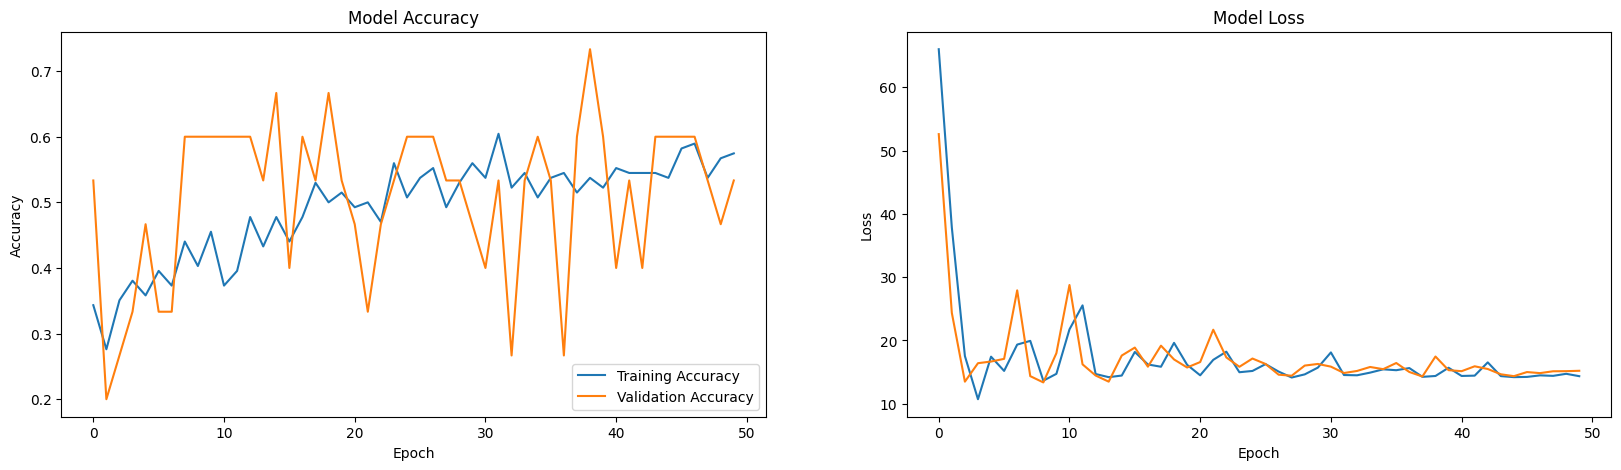

" \nplt.figure(figsize=(6, 6))\nplt.bar(['Average Performance'], [average_performance])\nplt.title('Average Validation Accuracy Across All Folds')\nplt.ylabel('Accuracy')\nplt.xlabel('Performance Metric')\n"

In [34]:
import matplotlib.pyplot as plt

def plot_history(history):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='lower right')

    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')

    plt.show()


print("val_accuracy: ", history.history['val_accuracy'])
print("accuracy: ", history.history['accuracy'])
print("val_loss: ", history.history['val_loss'])
print("loss: ", history.history['loss'])

plot_history(history)
#plot_history(hypermodel_history)


''' 
plt.figure(figsize=(6, 6))
plt.bar(['Average Performance'], [average_performance])
plt.title('Average Validation Accuracy Across All Folds')
plt.ylabel('Accuracy')
plt.xlabel('Performance Metric')
'''